In [12]:
import sys
sys.path.append('../')

,image_name,label,path,train,label_id,image_id
0,n07720875_1.JPEG,bell pepper,images/bell pepper/n07720875_1.JPEG,True,0,0
1,n07720875_10.JPEG,bell pepper,images/bell pepper/n07720875_10.JPEG,True,0,1
2,n07720875_101.JPEG,bell pepper,images/bell pepper/n07720875_101.JPEG,True,0,2
3,n07720875_104.JPEG,bell pepper,images/bell pepper/n07720875_104.JPEG,True,0,3


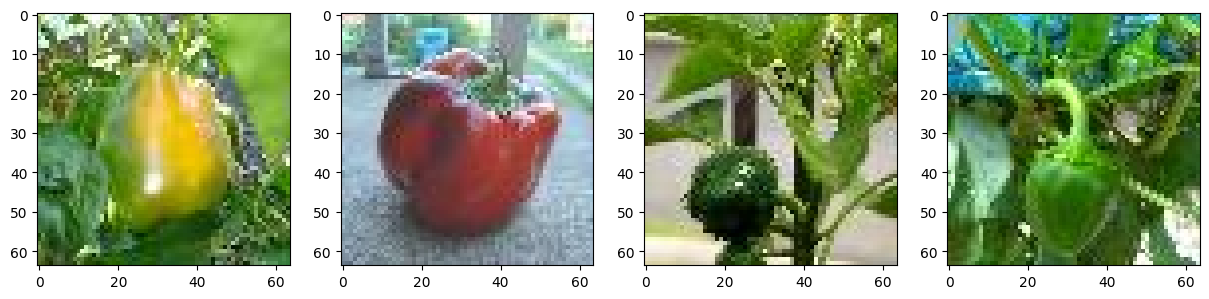

In [13]:
import cv2                      # Image Ops
import pandas as pd             # Other
import numpy as np              # Mat Opts
import matplotlib.pyplot as plt # Show Images

from utils.utils import load_images
from utils.features import load_features, save_features, extract_features
from utils.matching import minmin_retrival, match_all_images
from utils.scoring import calculate_metrics

from functools import partial

image_meta, images = load_images(True) # True - Train Images
display(image_meta.head(4))

_, ax = plt.subplots(1, 4, figsize = (15, 6))
ax[0].imshow(images[0]);
ax[1].imshow(images[1]);
ax[2].imshow(images[2]);
ax[3].imshow(images[3]);

In [14]:
def orb_descriptor(image, wta = 4):
    orb = cv2.ORB_create(nfeatures = 50, scoreType = cv2.ORB_HARRIS_SCORE, WTA_K = wta)
    img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    _, descs = orb.detectAndCompute(img, None)
    return descs

# Convertir las imágenes a escala de grises y aplicar SIFT en el subconjunto de imágenes
descriptors, index = extract_features(orb_descriptor, images, min_features=-1, progress = True)
print("Tamaño de  descriptores:", descriptors.shape[1])
print("Número de  descriptores:", descriptors.shape[0])
print("Número Máximo de Descriptores Por Imágen :", pd.value_counts(index).max())
print("Número Medio  de Descriptores Por Imágen :", pd.value_counts(index).mean().round(0).astype(int))
print("Número Mínimo de Descriptores Por Imágen :", pd.value_counts(index).min())

# Obligatorio Siempre Guardar
save_features(descriptors, index, image_meta, "ORB")

100%|██████████| 700/700 [00:00<00:00, 1783.94it/s]

Tamaño de  descriptores: 32
Número de  descriptores: 128
Número Máximo de Descriptores Por Imágen : 1
Número Medio  de Descriptores Por Imágen : 1
Número Mínimo de Descriptores Por Imágen : 1


In [15]:
desc_meta, descriptors = load_features("../features/ORB.csv") # Siempre Cargar

,image_name,label,path,train,label_id,image_id
0,n07720875_0.JPEG,bell pepper,images/bell pepper/n07720875_0.JPEG,False,0,0
1,n07720875_100.JPEG,bell pepper,images/bell pepper/n07720875_100.JPEG,False,0,1
2,n07720875_102.JPEG,bell pepper,images/bell pepper/n07720875_102.JPEG,False,0,2
3,n07720875_103.JPEG,bell pepper,images/bell pepper/n07720875_103.JPEG,False,0,3


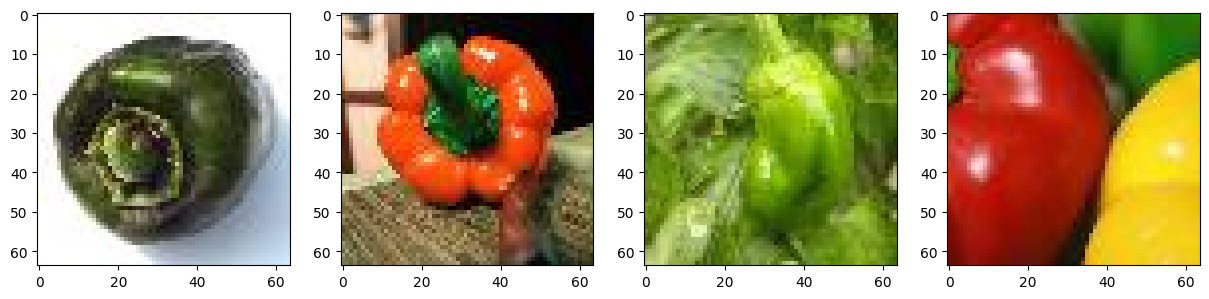

In [16]:
test_meta, test_images = load_images(False)

display(test_meta.head(4))

_, ax = plt.subplots(1, 4, figsize = (15, 6))
ax[0].imshow(test_images[0]);
ax[1].imshow(test_images[1]);
ax[2].imshow(test_images[2]);
ax[3].imshow(test_images[3]);


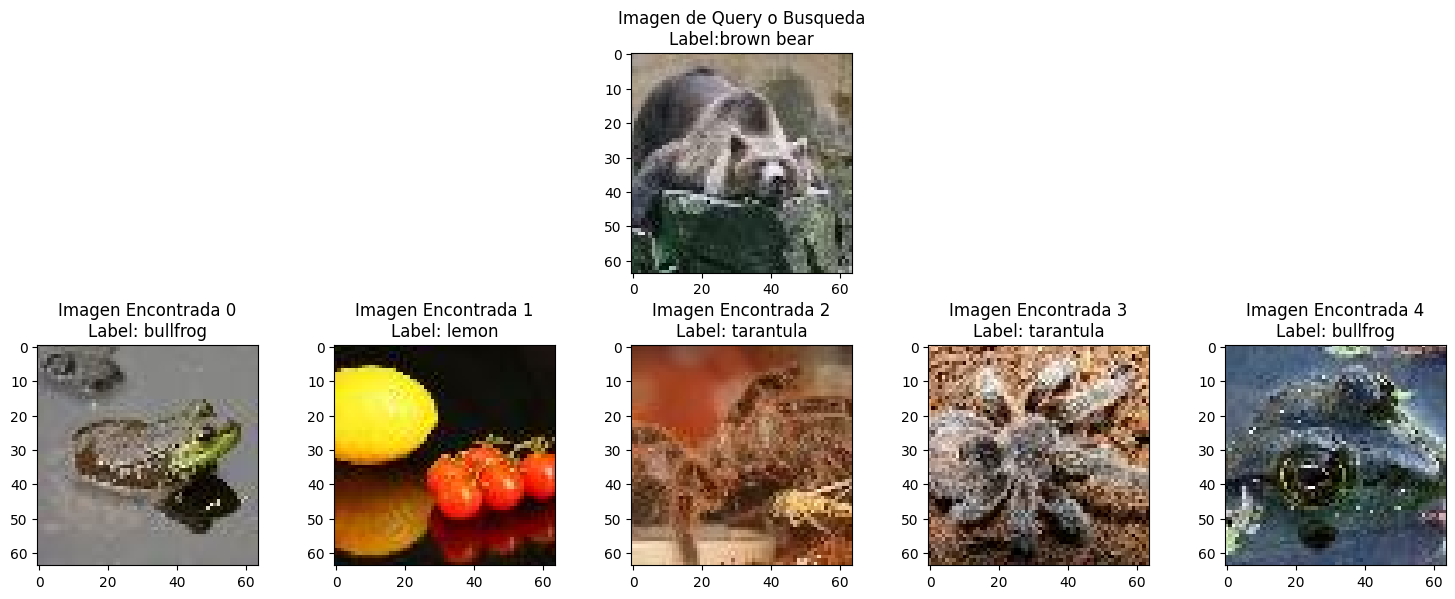

In [17]:
test_img = 50
img = test_images[test_img]
descs = orb_descriptor(img)
ret_idx = minmin_retrival(descs, descriptors, desc_meta, best_k=5, distance_function=cv2.NORM_HAMMING)

fig, ax = plt.subplots(2, 5,  figsize = (15, 6))

ax[0][2].imshow(test_images[test_img])
ax[0][2].set_title("Imagen de Query o Busqueda\nLabel:" + test_meta.loc[test_img, 'label'])
for i, img_id in enumerate(ret_idx[:5], start = 0):
    ax[1][i].imshow(images[img_id])
    label = image_meta.loc[img_id, 'label']
    ax[1][i].set_title(f"Imagen Encontrada {i}\nLabel: {label}");

fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][3])
fig.delaxes(ax[0][4])

fig.tight_layout()


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:00<00:00, 1911.02it/s]


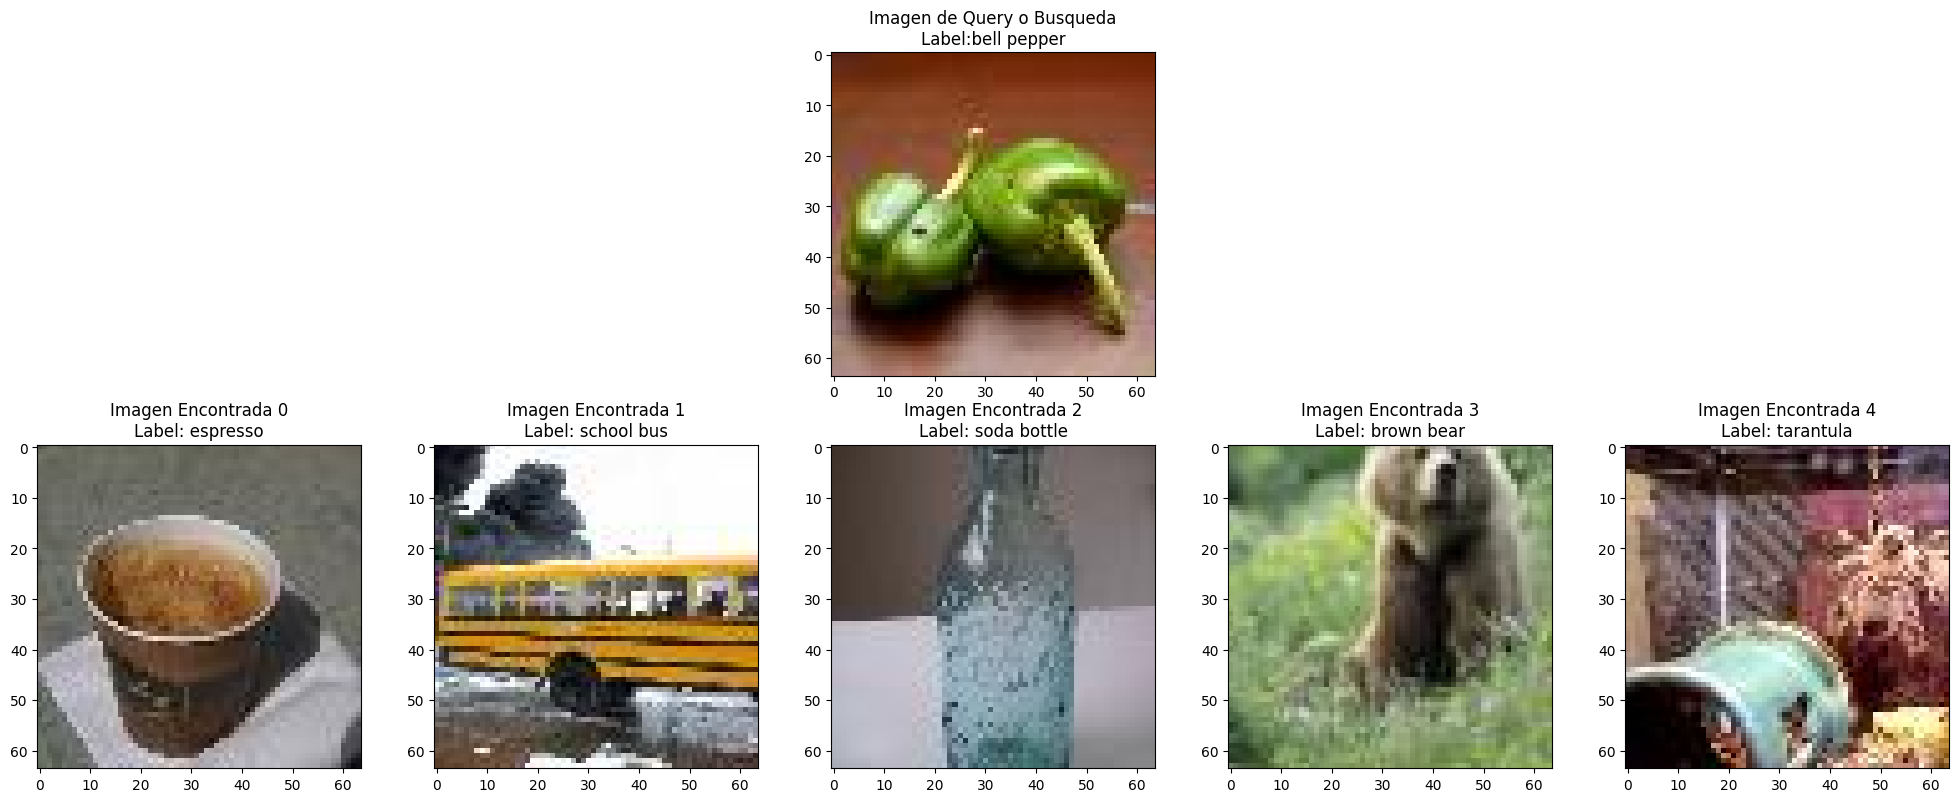

In [19]:
test_decs, test_desc_meta = extract_features(orb_descriptor, test_images, progress=True)

xr = match_all_images(test_decs, test_desc_meta, descriptors, desc_meta, best_k=50, distance_function=cv2.NORM_HAMMING)
fig, ax = plt.subplots(2, 5,  figsize = (20, 8))

test_img = 10
ax[0][2].imshow(test_images[test_img])
ax[0][2].set_title("Imagen de Query o Busqueda\nLabel:" + test_meta.loc[test_img, 'label'])
for i, img_id in enumerate(xr[test_img][:5], start = 0):
    ax[1][i].imshow(images[img_id])
    label = image_meta.loc[img_id, 'label']
    ax[1][i].set_title(f"Imagen Encontrada {i}\nLabel: {label}");

fig.delaxes(ax[0][0])
fig.delaxes(ax[0][1])
fig.delaxes(ax[0][3])
fig.delaxes(ax[0][4])

fig.tight_layout()


In [20]:
calculate_metrics(xr, image_meta, test_meta, scores = (1, 5, 10, 25, 50))

,Precision@K,Recall@K,R-Precision@K
K,,,
1,0.135593,0.001937,0.135593
5,0.166102,0.011864,0.166102
10,0.145763,0.020823,0.145763
25,0.141017,0.050363,0.141017
50,0.126780,0.090557,0.126780


100%|██████████| 3/3 [00:01<00:00,  2.04it/s]


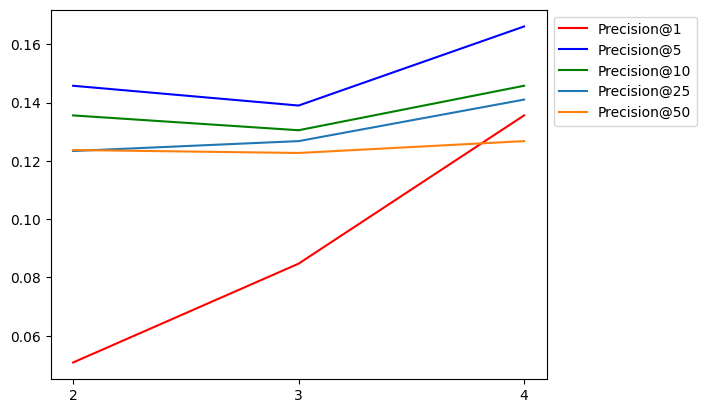

In [21]:
from tqdm import tqdm
rprecision1 = []
rprecision5 = []
rprecision10 = []
rprecision25 = []
rprecision50 = []
params = [2, 3, 4]
for wk in tqdm(params):
    orb_descriptor_func = partial(orb_descriptor, wta = wk) 

    train_desc, train_index = extract_features(orb_descriptor_func, images)
    test_desc , test_index  = extract_features(orb_descriptor_func, test_images)

    results = match_all_images(test_desc, test_index, train_desc, train_index, best_k=50, distance_function=cv2.NORM_HAMMING)
    rprecision = calculate_metrics(results, image_meta, test_meta, scores = (1, 5, 10, 25, 50))

    rprecision1.append( rprecision.loc[ 1, 'Precision@K'])
    rprecision5.append( rprecision.loc[ 5, 'Precision@K'])
    rprecision10.append(rprecision.loc[10, 'Precision@K'])
    rprecision25.append(rprecision.loc[25, 'Precision@K'])
    rprecision50.append(rprecision.loc[50, 'Precision@K'])

plt.plot(params, rprecision1 , 'r', label = "Precision@1")
plt.plot(params, rprecision5 , 'b', label = "Precision@5")
plt.plot(params, rprecision10, 'g', label = "Precision@10")
plt.plot(params, rprecision25,      label = "Precision@25")
plt.plot(params, rprecision50,      label = "Precision@50")
plt.xticks(params)
plt.legend(bbox_to_anchor = (1, 1))
plt.show()